# Importing libraries

In [7]:
import os
import re

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Audio
from keras import layers
from keras import models
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pickle
import itertools
import visualkeras

In [8]:
# Path to Audio Files

Crema = "/kaggle/input/cremad/AudioWAV/"

# Data preparation

CREMA-D is a data set of 7,442 original clips from 91 actors. These clips were from 48 male and 43 female actors between the ages of 20 and 74 coming from a variety of races and ethnicities (African America, Asian, Caucasian, Hispanic, and Unspecified). Actors spoke from a selection of 12 sentences. The sentences were presented using one of six different emotions (Anger, Disgust, Fear, Happy, Neutral, and Sad) and four different emotion levels (Low, Medium, High, and Unspecified).

In [9]:
emotion_df = []

for wav in os.listdir(Crema):
    info = wav.partition(".wav")[0].split("_")
    if info[2] == 'SAD':
        emotion_df.append(("sad", Crema + "/" + wav))
    elif info[2] == 'ANG':
        emotion_df.append(("angry", Crema + "/" + wav))
    elif info[2] == 'DIS':
        emotion_df.append(("disgust", Crema + "/" + wav))
    elif info[2] == 'FEA':
        emotion_df.append(("fear", Crema + "/" + wav))
    elif info[2] == 'HAP':
        emotion_df.append(("happy", Crema + "/" + wav))
    elif info[2] == 'NEU':
        emotion_df.append(("neutral", Crema + "/" + wav))
    else:
        emotion_df.append(("unknown", Crema + "/" + wav))


Crema_df = pd.DataFrame.from_dict(emotion_df)
Crema_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Crema_df.head()

,Emotion,Path
0,disgust,/kaggle/input/cremad/AudioWAV//1028_TSI_DIS_XX...
1,happy,/kaggle/input/cremad/AudioWAV//1075_IEO_HAP_LO...
2,happy,/kaggle/input/cremad/AudioWAV//1084_ITS_HAP_XX...
3,disgust,/kaggle/input/cremad/AudioWAV//1067_IWW_DIS_XX...
4,disgust,/kaggle/input/cremad/AudioWAV//1066_TIE_DIS_XX...


In [10]:
df = Crema_df.copy()
df.shape
df.head(10)

,Emotion,Path
0,disgust,/kaggle/input/cremad/AudioWAV//1028_TSI_DIS_XX...
1,happy,/kaggle/input/cremad/AudioWAV//1075_IEO_HAP_LO...
2,happy,/kaggle/input/cremad/AudioWAV//1084_ITS_HAP_XX...
3,disgust,/kaggle/input/cremad/AudioWAV//1067_IWW_DIS_XX...
4,disgust,/kaggle/input/cremad/AudioWAV//1066_TIE_DIS_XX...
5,disgust,/kaggle/input/cremad/AudioWAV//1027_DFA_DIS_XX...
6,happy,/kaggle/input/cremad/AudioWAV//1032_IEO_HAP_HI...
7,sad,/kaggle/input/cremad/AudioWAV//1023_TIE_SAD_XX...
8,disgust,/kaggle/input/cremad/AudioWAV//1041_TAI_DIS_XX...
9,sad,/kaggle/input/cremad/AudioWAV//1004_WSI_SAD_XX...


# Exploratory Data Analysis

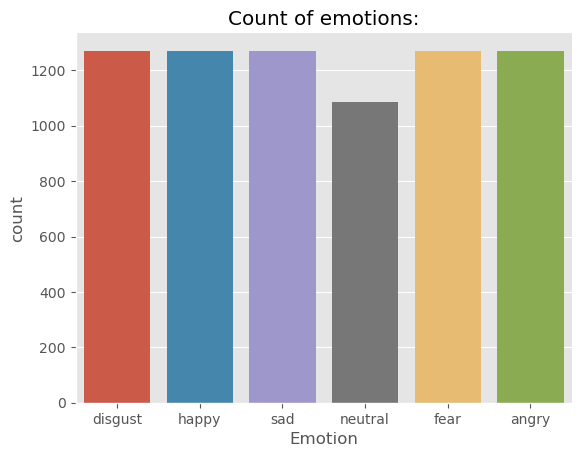

In [11]:
%matplotlib inline

plt.style.use("ggplot")

plt.title("Count of emotions:")
sns.countplot(x=df["Emotion"])
plt.savefig("/kaggle/working/Emotion_Count.eps")
sns.despine(top=True, right=True, left=False, bottom=False)

In [12]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    librosa.display.waveshow(data, sr=sr, color="purple")
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

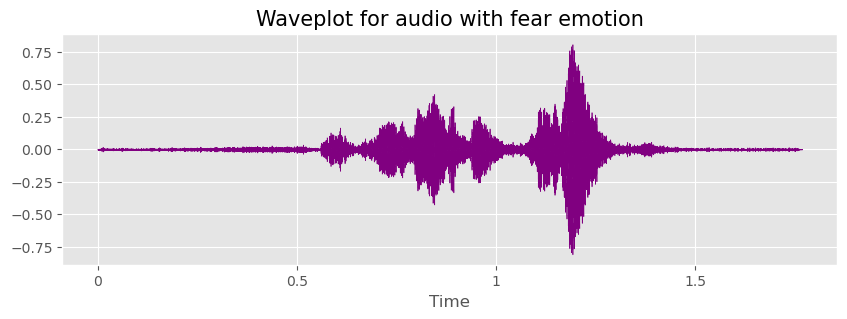

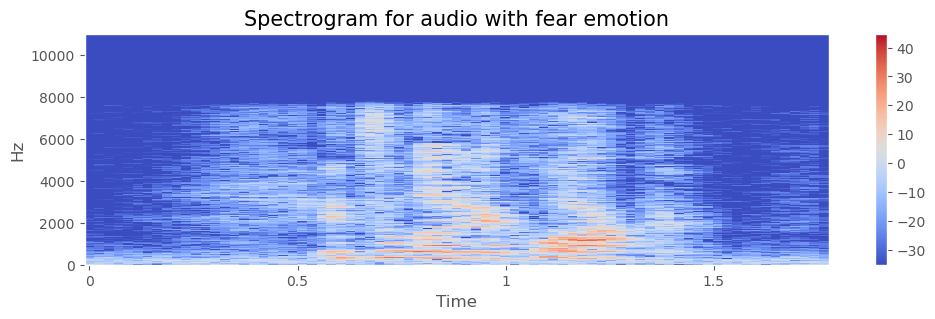

In [13]:
emotion='fear'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

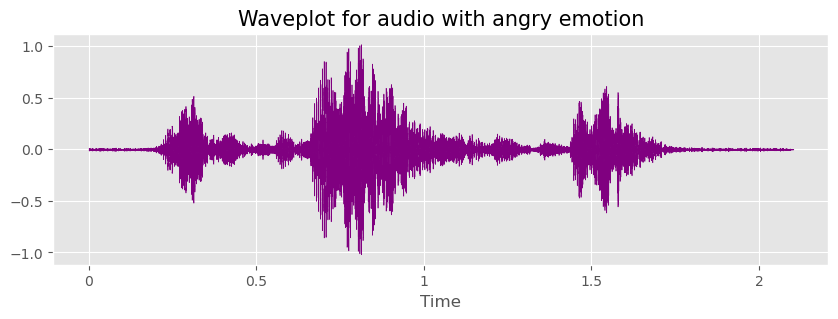

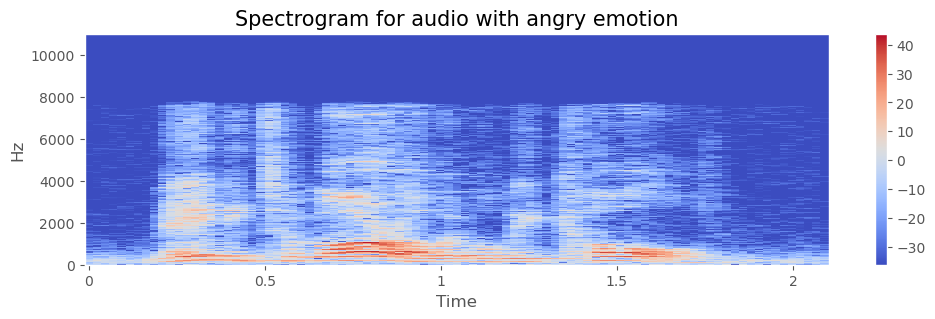

In [14]:
emotion='angry'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

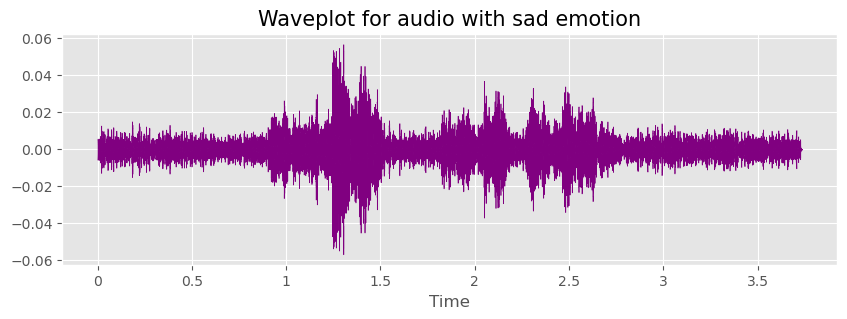

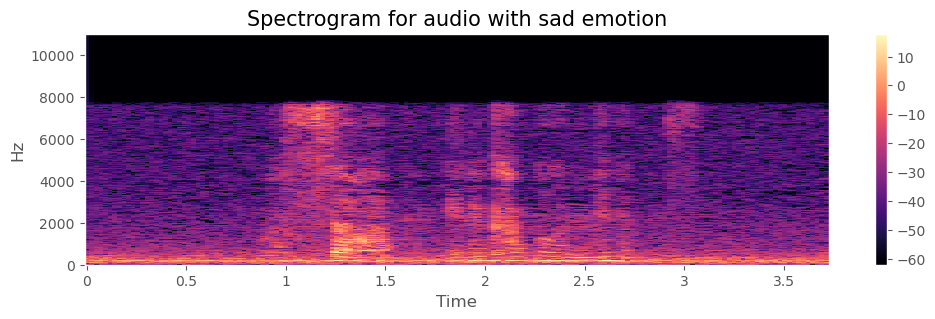

In [15]:
emotion='sad'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

# Data Augmentation
Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.

There are lot of ways for data augmentation in sound data, we will use following in this project:

1. Noise injection
2. Stretching
3. Shifting
4. Pitching

In [16]:
def noise(data, random=False, rate=0.035, threshold=0.075):
    """Add some noise to sound sample. Use random if you want to add random noise with some threshold.
    Or use rate Random=False and rate for always adding fixed noise."""
    if random:
        rate = np.random.random() * threshold
    noise_amp = rate*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data):
    """Stretching data with some rate."""
    return librosa.effects.time_stretch(data, rate=0.5)

def shift(data, rate=1000):
    """Shifting data with some rate"""
    shift_range = int(np.random.uniform(low=-5, high = 5)*rate)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor, random=False):
    """"Add some pitch to sound sample. Use random if you want to add random pitch with some threshold.
    Or use pitch_factor Random=False and rate for always adding fixed pitch."""
    if random:
        pitch_factor=np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

In [17]:
# Taking one sample from the dataset to check Data Augmentation techniques

path = df[df["Emotion"] == "happy"]["Path"].iloc[0]
data, sampling_rate = librosa.load(path)

1. Simple Audio

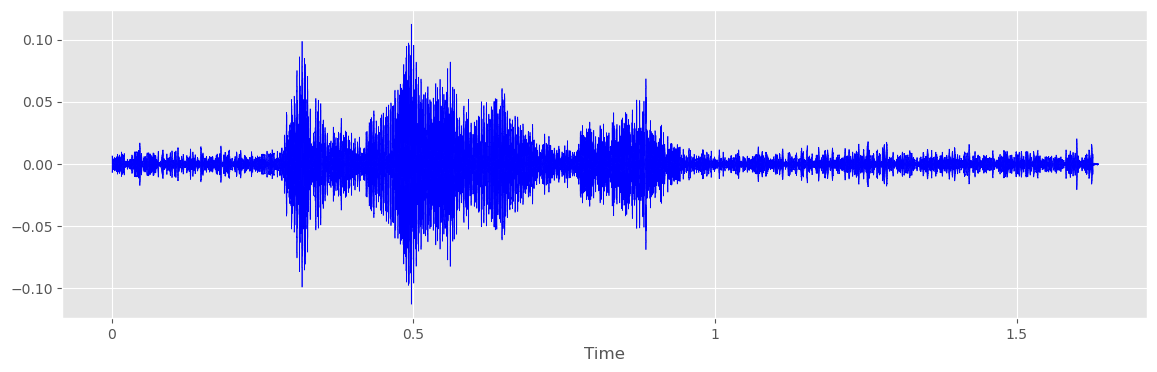

In [18]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(data, sr=sampling_rate, color="blue")
Audio(path)

2. Noisy data

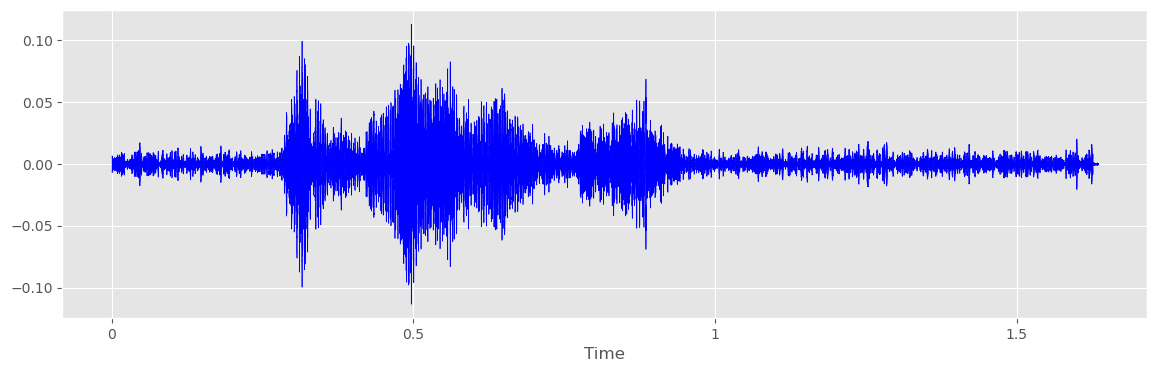

In [19]:
noised_data = noise(data, random=True)
plt.figure(figsize=(14,4))
librosa.display.waveshow(noised_data, sr=sampling_rate, color="blue")
Audio(noised_data, rate=sampling_rate)

3. Stretching

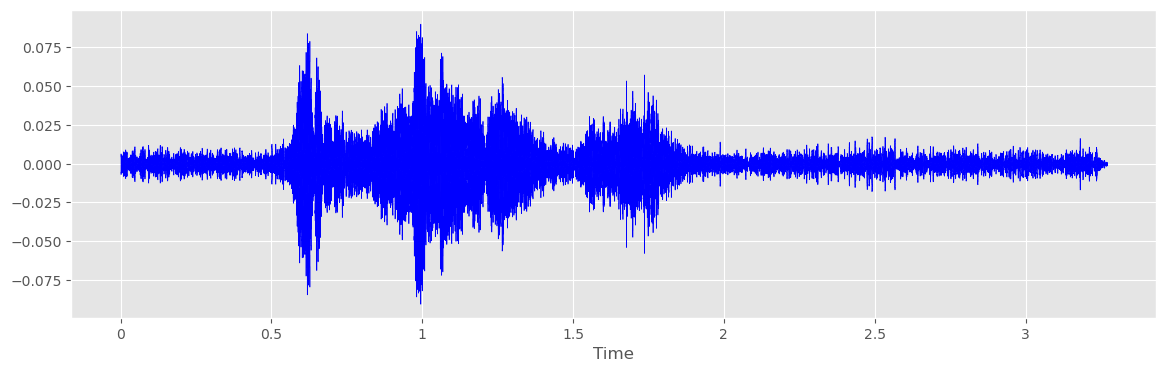

In [20]:

stretched_data = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(stretched_data, sr=sampling_rate, color="blue")
Audio(stretched_data, rate=sampling_rate)

4. Shifting

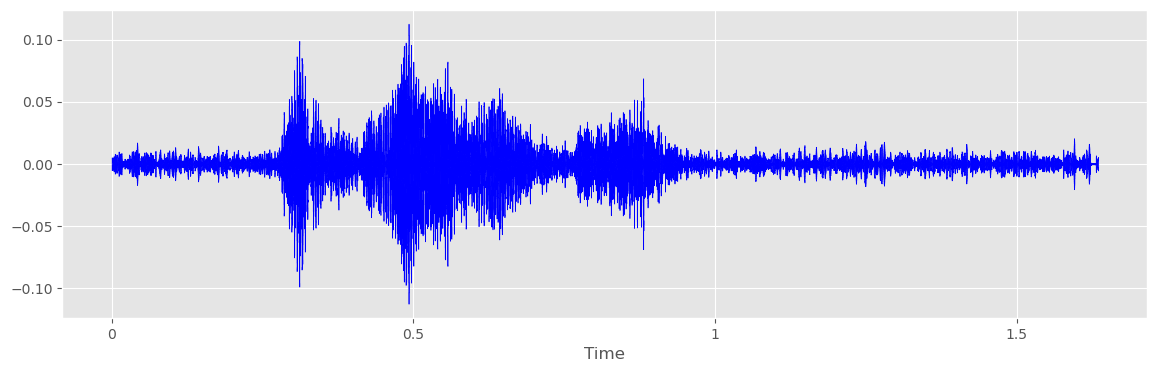

In [21]:
shifted_data = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=shifted_data, sr=sampling_rate, color="blue")
Audio(shifted_data, rate=sampling_rate)

5. Pitching

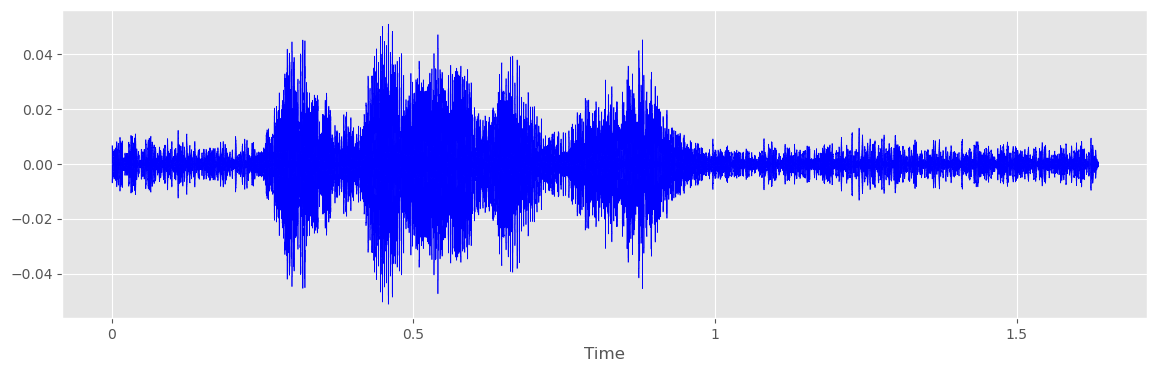

In [22]:
pitched_data = pitch(data, sampling_rate, pitch_factor=3,random=False)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=pitched_data, sr=sampling_rate, color="blue")
Audio(pitched_data, rate=sampling_rate)

# Feature Extraction
Extraction of features is a very important part in analyzing and finding relations between different things. As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.

The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.

There are several data transormation methods with the help of sample rate and sample data are as follow:

1. Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
2. Energy : The sum of squares of the signal values, normalized by the respective frame length.
3. Entropy of Energy :The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
4. Spectral Centroid : The center of gravity of the spectrum.
5. Spectral Spread : The second central moment of the spectrum.
6. Spectral Entropy : Entropy of the normalized spectral energies for a set of sub-frames.
7. Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the    two successive frames.
8. Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum    is concentrated.
9. MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency      bands are not linear but distributed according to the mel-scale.

In [23]:
n_fft = 2048
hop_length = 512

def chunks(data, frame_length, hop_length):
    for i in range(0, len(data), hop_length):
        yield data[i:i+frame_length]

# Zero Crossing Rate
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)


def energy(data, frame_length=2048, hop_length=512):
    en = np.array([np.sum(np.power(np.abs(data[hop:hop+frame_length]), 2)) for hop in range(0, data.shape[0], hop_length)])
    return en / frame_length


def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)


def entropy_of_energy(data, frame_length=2048, hop_length=512):
    energies = energy(data, frame_length, hop_length)
    energies /= np.sum(energies)

    entropy = 0.0
    entropy -= energies * np.log2(energies)
    return entropy


def spc(data, sr, frame_length=2048, hop_length=512):
    spectral_centroid = librosa.feature.spectral_centroid(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spectral_centroid)


def spc_flux(data):
    isSpectrum = data.ndim == 1
    if isSpectrum:
        data = np.expand_dims(data, axis=1)

    X = np.c_[data[:, 0], data]
    af_Delta_X = np.diff(X, 1, axis=1)
    vsf = np.sqrt((np.power(af_Delta_X, 2).sum(axis=0))) / X.shape[0]

    return np.squeeze(vsf) if isSpectrum else vsf


def spc_rollof(data, sr, frame_length=2048, hop_length=512):
    spcrollof = librosa.feature.spectral_rolloff(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spcrollof)


def chroma_stft(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    stft = np.abs(librosa.stft(data))
    chroma_stft = librosa.feature.chroma_stft(S=stft, sr=sr)
    return np.squeeze(chroma_stft.T) if not flatten else np.ravel(chroma_stft.T)


def mel_spc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mel = librosa.feature.melspectrogram(y=data, sr=sr)
    return np.squeeze(mel.T) if not flatten else np.ravel(mel.T)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

In [24]:
# Taking one sample from the dataset to perform data tranformation techniques on it

path = np.array(df["Path"])[658]
data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
len(data)

33857

In [25]:
print("ZCR: ", zcr(data).shape)
print("Energy: ", energy(data).shape)
print("Entropy of Energy :", entropy_of_energy(data).shape)
print("RMS :", rmse(data).shape)
print("Spectral Centroid :", spc(data, sampling_rate).shape)
# print("Spectral Entropy: ", spc_entropy(data, sampling_rate).shape)
print("Spectral Flux: ", spc_flux(data).shape)
print("Spectral Rollof: ", spc_rollof(data, sampling_rate).shape)
print("Chroma STFT: ", chroma_stft(data, sampling_rate).shape)
print("MelSpectrogram: ", mel_spc(data, sampling_rate).shape)
print("MFCC: ", mfcc(data, sampling_rate).shape)

ZCR:  (67,)
Energy:  (67,)
Entropy of Energy : (67,)
RMS : (67,)
Spectral Centroid : (67,)
Spectral Flux:  ()
Spectral Rollof:  (67,)
Chroma STFT:  (804,)
MelSpectrogram:  (8576,)
MFCC:  (1340,)


In this project we will use 3 main Data Transformation features : ZCR, RMS and MFCC.

Also we will use just 2.5s duration with 0.6 offset. In the dataset first 0.6s contains no information about emotion, and most of them are less then 3s.

In [26]:
def extract_features(data, sr, frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        rmse(data, frame_length, hop_length),
                        mfcc(data, sr, frame_length, hop_length)
                        #chroma_stft(data, sr, frame_length, hop_length),
                        #mel_spc(data, sr, frame_length, hop_length),
                        #spc(data, sr, frame_length=2048, hop_length=512),
                        #spc_rollof(data, sr, frame_length=2048, hop_length=512),
                        #entropy_of_energy(data, frame_length=2048, hop_length=512)
                        ))
    return result

In [27]:
def get_features(path, duration=2.5, offset=0.6):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=duration, offset=offset)

     # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data, random=True)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically

    # data with pitching
    pitched_data = pitch(data, sample_rate, pitch_factor=3, random=False)
    
    res3 = extract_features(pitched_data, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    # data with pitching and noise
    new_data = pitch(data, sample_rate, pitch_factor=3, random=False)
    data_noise_pitch = noise(new_data, random=True)
    res3 = extract_features(data_noise_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [28]:
X, Y = [], []
for path, emotion in zip(df.Path, df.Emotion):
    features = get_features(path)
    for ele in features:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [29]:
features_path = "features.csv"

In [30]:
extracted_df = pd.DataFrame(X)
extracted_df["labels"] = Y
extracted_df.to_csv(features_path, index=False)

In [31]:
extracted_df = pd.read_csv("/kaggle/working/features.csv")
print(extracted_df.shape)

(29768, 2377)


In [32]:
# Fill NaN with 0
extracted_df = extracted_df.fillna(0)
print(extracted_df.isna().any())
extracted_df.shape

0         False
1         False
2         False
3         False
4         False
          ...  
2372      False
2373      False
2374      False
2375      False
labels    False
Length: 2377, dtype: bool


(29768, 2377)

In [33]:
extracted_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,labels
0,0.122070,0.187988,0.235840,0.249512,0.249512,0.245605,0.237305,0.183594,0.124512,0.073730,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,disgust
1,0.123047,0.183594,0.232910,0.250488,0.258301,0.268066,0.272461,0.215820,0.156738,0.101074,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,disgust
2,0.128906,0.178223,0.243652,0.241699,0.263672,0.281738,0.247070,0.206543,0.135254,0.081543,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,disgust
3,0.126953,0.177246,0.240723,0.242676,0.260742,0.281738,0.249023,0.206543,0.139160,0.081543,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,disgust
4,0.016113,0.021484,0.029297,0.030762,0.033691,0.036133,0.038574,0.046875,0.054688,0.062500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,happy


# Data Preparation
As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [34]:
X = extracted_df.drop(labels="labels", axis=1)
Y = extracted_df["labels"]

In [35]:
# Encoding Emotion Labels with LabelEncoder()

lb = LabelEncoder()
Y = np_utils.to_categorical(lb.fit_transform(Y))
print(lb.classes_)
Y

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']


array([[0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [36]:
# saving flattened format of LabelEncoder using pickle for further usage
filename = "Enc_labels.sav"
pickle.dump(lb,open(filename,"wb"))

In [37]:
t_lb = pickle.load(open("Enc_labels.sav","rb"))
t_lb.classes_

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad'],
      dtype=object)

In [38]:
# Splitting data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((23814, 2376), (5954, 2376), (23814, 6), (5954, 6))

In [39]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.1, shuffle=True)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((21432, 2376), (5954, 2376), (2382, 2376), (21432, 6), (5954, 6), (2382, 6))

In [40]:
# Feature Scaling using Standard Scaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((21432, 2376), (5954, 2376), (2382, 2376), (21432, 6), (5954, 6), (2382, 6))

In [41]:
scaling_Parameters = pd.DataFrame({"Mean":scaler.mean_, "Var":scaler.var_})
scaling_Parameters.to_csv("Scaling_Parameters_copy")

In [42]:
# We have to use 1-dimensional CNN for which we need specific shape
X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(21432, 2376, 1)

# Let's define our model:

In [57]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, LSTM, Bidirectional
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint
import visualkeras

In [58]:
model = Sequential()
model.add(layers.Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu",
                        input_shape=(X_train.shape[1], 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(256, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(layers.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

model.add(layers.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(6, activation="softmax"))


model.compile(optimizer = 'Adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 2376, 512)         3072      
                                                                 
 batch_normalization_9 (Batc  (None, 2376, 512)        2048      
 hNormalization)                                                 
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 1188, 512)        0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 1188, 512)         1311232   
                                                                 
 batch_normalization_10 (Bat  (None, 1188, 512)        2048      
 chNormalization)                                                
                                                      

In [59]:
rlrp = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
earlystopping = EarlyStopping(monitor ="val_accuracy",
                              mode = 'auto', patience = 5,
                              restore_best_weights = True)

history=model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_val, y_val), callbacks=[rlrp])

Epoch 1/50
335/335 [==============================] - 65s 173ms/step - loss: 1.5145 - accuracy: 0.3902 - val_loss: 1.9033 - val_accuracy: 0.2490 - lr: 0.0010
Epoch 2/50
335/335 [==============================] - 57s 171ms/step - loss: 1.3502 - accuracy: 0.4580 - val_loss: 1.4687 - val_accuracy: 0.4060 - lr: 0.0010
Epoch 3/50
335/335 [==============================] - 57s 172ms/step - loss: 1.2491 - accuracy: 0.5020 - val_loss: 1.3220 - val_accuracy: 0.4731 - lr: 0.0010
Epoch 4/50
335/335 [==============================] - 57s 171ms/step - loss: 1.1535 - accuracy: 0.5442 - val_loss: 1.2823 - val_accuracy: 0.4975 - lr: 0.0010
Epoch 5/50
335/335 [==============================] - 56s 168ms/step - loss: 1.0214 - accuracy: 0.6020 - val_loss: 1.2182 - val_accuracy: 0.5420 - lr: 0.0010
Epoch 6/50
335/335 [==============================] - 56s 168ms/step - loss: 0.8794 - accuracy: 0.6642 - val_loss: 1.0188 - val_accuracy: 0.6100 - lr: 0.0010
Epoch 7/50
335/335 [==============================] 

187/187 [==============================] - 4s 24ms/step - loss: 0.2047 - accuracy: 0.9552
Accuracy of our model on test data :  95.52 %


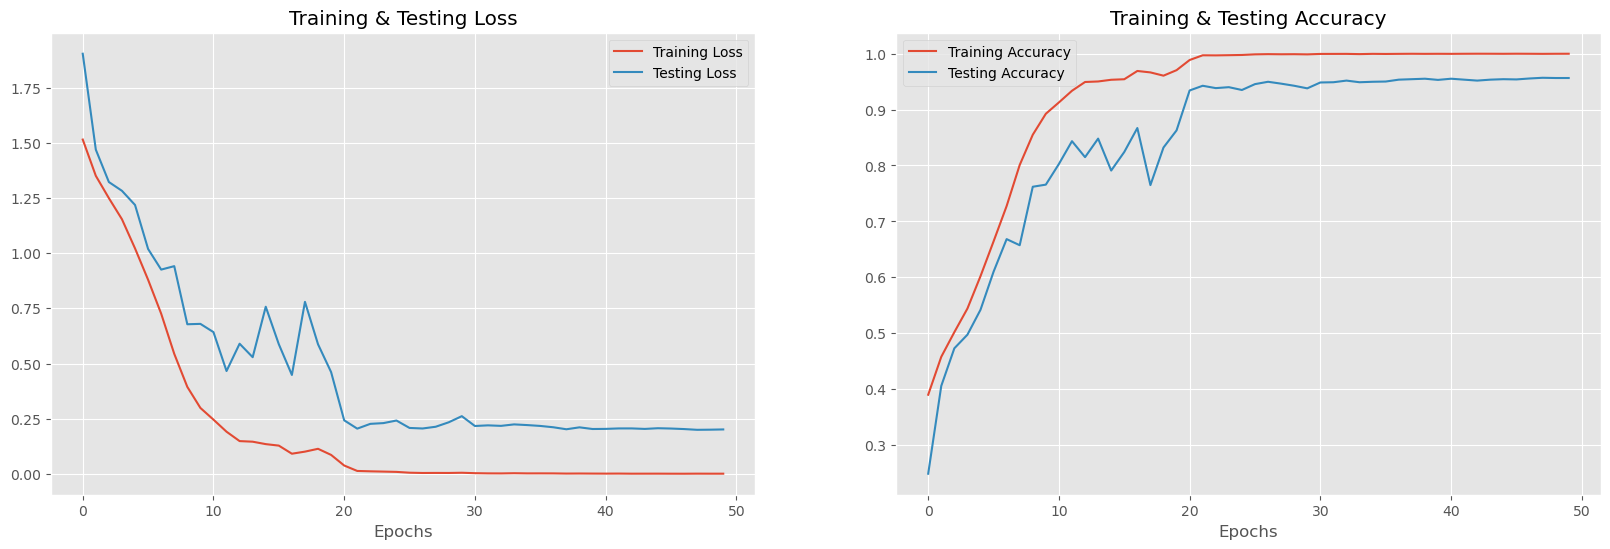

In [69]:
print("Accuracy of our model on test data : " , round(model.evaluate(X_test,y_test)[1]*100,2) , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.savefig("/kaggle/working/training-testing.eps")

plt.show()

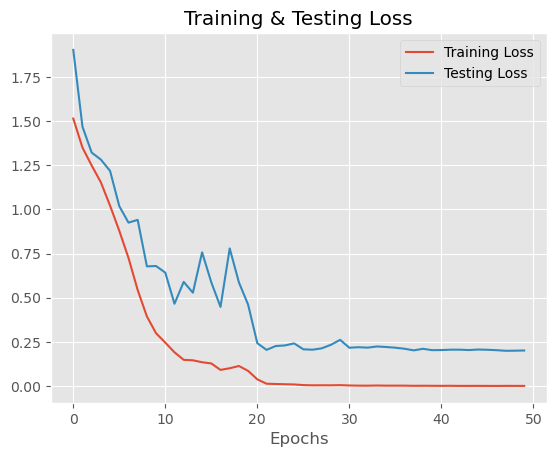

In [73]:
plt.plot(epochs , train_loss , label = 'Training Loss')
plt.plot(epochs , test_loss , label = 'Testing Loss')
plt.title('Training & Testing Loss')
plt.legend()
plt.xlabel("Epochs")
plt.savefig("/kaggle/working/training-testing-loss.eps")
plt.show()

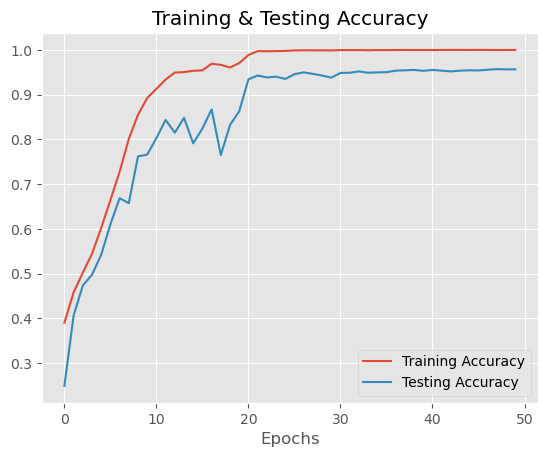

In [72]:
plt.plot(epochs , train_acc , label = 'Training Accuracy')
plt.plot(epochs , test_acc , label = 'Testing Accuracy')
plt.title('Training & Testing Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.savefig("/kaggle/working/training-testing-accuracy.eps")
plt.show()

In [61]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred_class = [lb.classes_[idx] for idx in y_pred ]

187/187 [==============================] - 4s 21ms/step


In [62]:
y_test_class = np.argmax(y_test, axis=1)
y_test_class = [lb.classes_[idx] for idx in y_test_class ]

In [63]:
result = pd.DataFrame({"Actual":y_test_class, "Predicted":y_pred_class})
result

,Actual,Predicted
0,angry,angry
1,angry,angry
2,fear,fear
3,sad,sad
4,neutral,neutral
...,...,...
5949,neutral,neutral
5950,disgust,disgust
5951,angry,angry
5952,happy,happy


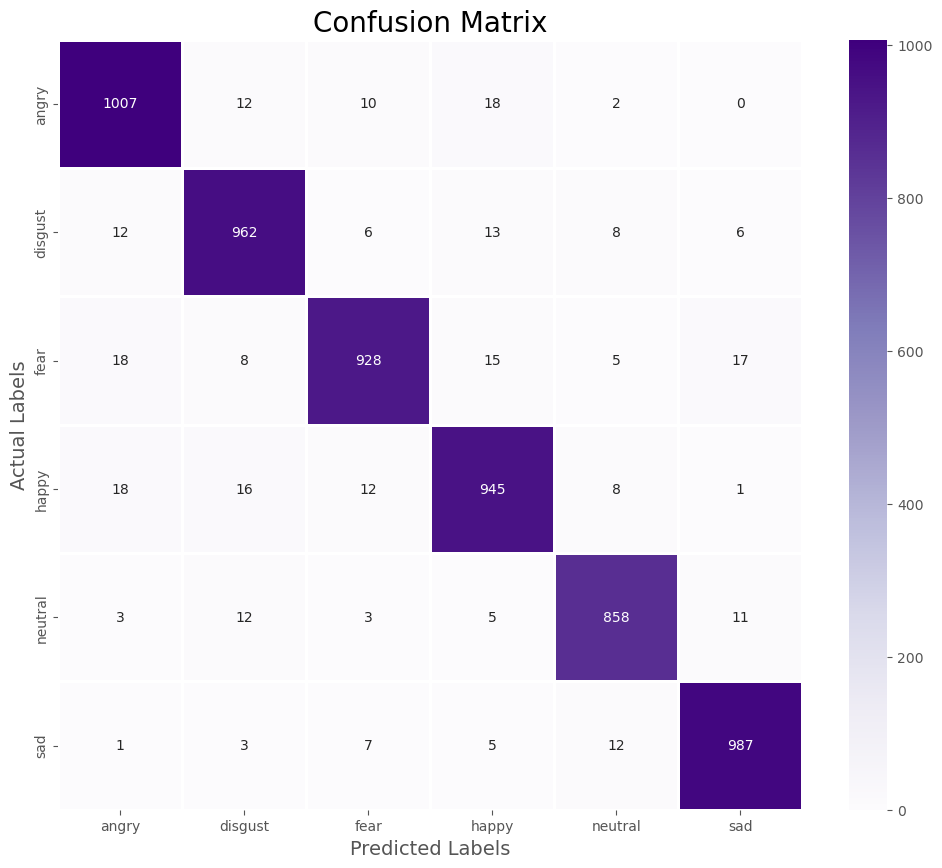

In [64]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_class, y_pred_class)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
sns.heatmap(cm, linecolor='white', cmap='Purples', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig("/kaggle/working/output.eps")
plt.show()

In [65]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test_class, y_pred_class))

              precision    recall  f1-score   support

       angry       0.95      0.96      0.96      1049
     disgust       0.95      0.96      0.95      1007
        fear       0.96      0.94      0.95       991
       happy       0.94      0.94      0.94      1000
     neutral       0.96      0.96      0.96       892
         sad       0.97      0.97      0.97      1015

    accuracy                           0.96      5954
   macro avg       0.96      0.96      0.96      5954
weighted avg       0.96      0.96      0.96      5954

